<a href="https://colab.research.google.com/github/simonians/Trabajo-integrador-RedesNeuronales-AutoencoderConvolutional/blob/main/Autoencoder_Convolutional_TrabajoIntegrador.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torchvision import datasets
import torchvision.transforms as transforms

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets 60k de train y 10 de test
train_data = datasets.MNIST(root='data', train=True,download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,download=True, transform=transform)

In [ ]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class DeNoiser(nn.Module):
    def __init__(self):
        super(DeNoiser, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 32), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  
        # conv layer (depth from 32 --> 16), 3x3 kernels
        self.conv2 = nn.Conv2d(32, 16, 3, padding=1)
        # conv layer (depth from 16 --> 8), 3x3 kernels
        self.conv3 = nn.Conv2d(16, 8, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        # transpose layer, a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(8, 8, 3, stride=2)  # kernel_size=3 to get to a 7x7 image output ...porque outputsize(7) = (3-1)*2+3=(inputsize-1) * stride + kernel
        # two more transpose layers with a kernel of 2
        self.t_conv2 = nn.ConvTranspose2d(8, 16, 2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(16, 32, 2, stride=2)
        # one, final, normal conv layer to decrease the depth
        self.conv_out = nn.Conv2d(32, 1, 3, padding=1)


    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # add third hidden layer
        x = F.relu(self.conv3(x))
        x = self.pool(x)  # compressed representation, termina con un 3x3x8 tras el pooling al 7x7x8
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        # transpose again, output should have a sigmoid applied
        x = F.sigmoid(self.conv_out(x))
                
        return x


In [ ]:
model = DeNoiser()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)


In [ ]:
# Loss function
Laslosses=[] #Para graficar la evolucion de los errores
criterion = nn.MSELoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)


# for adding noise to images
noise_factor=0.5
epochs = 20
for e in range(1, epochs+1):
    train_loss = 0.0  # monitor training loss
    
    for data in train_loader:
        images, _ = data                        # we are just intrested in images
        # no need to flatten images
        ## add random noise to the input images
        noisy_imgs = images #+ noise_factor * torch.randn(*images.shape) #Se lo sacamos para probar
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        optimizer.zero_grad()                   # clear the gradients
        outputs = model(noisy_imgs)             # forward pass: compute predicted outputs 
        loss = criterion(outputs, images)       # calculate the loss
        loss.backward()                         # backward pass
        optimizer.step()                        # perform optimization step
        train_loss += loss.item()*images.size(0)# update running training loss
    

            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {}'.format(e),
          '\tTraining Loss: {:.4f}'.format(train_loss))
    Laslosses.append(train_loss)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 0.6979
Epoch: 2 	Training Loss: 0.3923
Epoch: 3 	Training Loss: 0.3539
Epoch: 4 	Training Loss: 0.3347
Epoch: 5 	Training Loss: 0.3218
Epoch: 6 	Training Loss: 0.3122
Epoch: 7 	Training Loss: 0.3044
Epoch: 8 	Training Loss: 0.2981
Epoch: 9 	Training Loss: 0.2926
Epoch: 10 	Training Loss: 0.2878
Epoch: 11 	Training Loss: 0.2835
Epoch: 12 	Training Loss: 0.2796
Epoch: 13 	Training Loss: 0.2762
Epoch: 14 	Training Loss: 0.2731
Epoch: 15 	Training Loss: 0.2701
Epoch: 16 	Training Loss: 0.2674
Epoch: 17 	Training Loss: 0.2649
Epoch: 18 	Training Loss: 0.2624
Epoch: 19 	Training Loss: 0.2600
Epoch: 20 	Training Loss: 0.2579


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


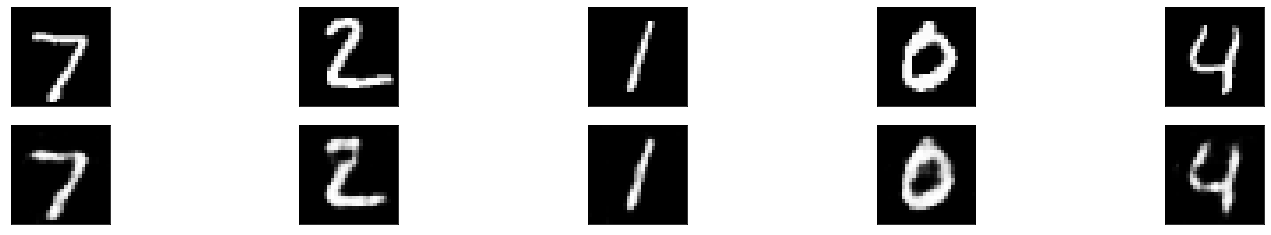

In [ ]:
# Lets get batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# add noise to the test images, se lo sacamos porque no lo vimos
noisy_imgs = images #+ noise_factor * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

output = model(noisy_imgs)                 # get sample outputs
noisy_imgs = noisy_imgs.numpy()            # prep images for display
output = output.view(batch_size, 1, 28, 28)# resizing output
output = output.detach().numpy()           # use detach when it's an output that requires_grad

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(25,4))
# input images on top row, reconstructions on bottom
for noisy_imgs, row in zip([noisy_imgs, output], axes):
    for img, ax in zip(noisy_imgs, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


In [ ]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'Epochs')

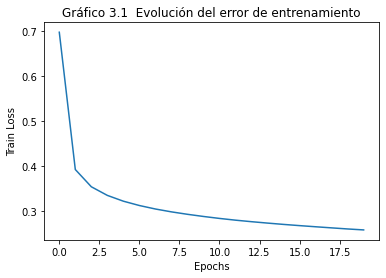

In [ ]:
plt.plot(Laslosses)
plt.title("Gráfico 3.1  Evolución del error de entrenamiento")
plt.ylabel('Train Loss')
plt.xlabel('Epochs')

In [ ]:
train_loss_ff=[1.0233129382133483, 0.285541732609272, 0.23957694818576178, 0.22691820661226908, 0.2207131008307139, 0.2168519154191017, 0.2144155556956927, 0.21242308815320332, 0.2109979341427485, 0.2097204275429249, 0.20914018402496973, 0.20831065128246942, 0.20764591718713443, 0.20651225447654725, 0.20592516536513963, 0.20535298436880112, 0.2047993761797746, 0.20425622090697287, 0.20418672064940135, 0.20379667257269224]

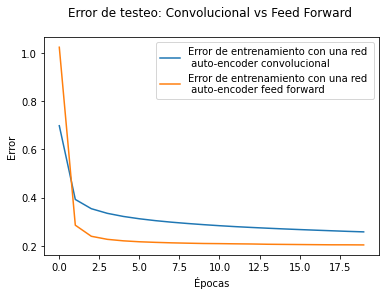

In [ ]:
fig, ax = plt.subplots()
ax.plot(Laslosses,label='Error de entrenamiento con una red \n auto-encoder convolucional')
ax.plot(train_loss_ff,label='Error de entrenamiento con una red \n auto-encoder feed forward')
ax.set_title("Error de testeo: Convolucional vs Feed Forward \n")
ax.set_xlabel('Épocas')  
ax.set_ylabel('Error')
ax.legend()